In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [2]:
# I had to slightly edit the source code from networkx
def powerlaw_cluster_graph(n, m, p, initial_graph, seed=random.seed(2)):
    """Holme and Kim algorithm for growing graphs with powerlaw
    degree distribution and approximate average clustering.

    Parameters
    ----------
    n : int
        the number of nodes
    m : int
        the number of random edges to add for each new node
    p : float,
        Probability of adding a triangle after adding a random edge
    seed : integer, random_state, or None (default)
        Indicator of random number generation state.
        See :ref:`Randomness<randomness>`.

    Notes
    -----
    The average clustering has a hard time getting above a certain
    cutoff that depends on `m`.  This cutoff is often quite low.  The
    transitivity (fraction of triangles to possible triangles) seems to
    decrease with network size.

    It is essentially the Barabási–Albert (BA) growth model with an
    extra step that each random edge is followed by a chance of
    making an edge to one of its neighbors too (and thus a triangle).

    This algorithm improves on BA in the sense that it enables a
    higher average clustering to be attained if desired.

    It seems possible to have a disconnected graph with this algorithm
    since the initial `m` nodes may not be all linked to a new node
    on the first iteration like the BA model.

    Raises
    ------
    NetworkXError
        If `m` does not satisfy ``1 <= m <= n`` or `p` does not
        satisfy ``0 <= p <= 1``.

    References
    ----------
    .. [1] P. Holme and B. J. Kim,
       "Growing scale-free networks with tunable clustering",
       Phys. Rev. E, 65, 026107, 2002.
    """

    if m < 1 or n < m:
        raise nx.NetworkXError(f"NetworkXError must have m>1 and m<n, m={m},n={n}")

    if p > 1 or p < 0:
        raise nx.NetworkXError(f"NetworkXError p must be in [0,1], p={p}")

    # initializing with a given graph instead of random nodes
    G = initial_graph  # add m initial nodes (m0 in barabasi-speak)
    repeated_nodes = list(G.nodes())  # list of existing nodes to sample from
    # with nodes repeated once for each adjacent edge
    source = m  # next node is m
    while source < n:  # Now add the other n-1 nodes
        possible_targets = _random_subset(repeated_nodes, m, seed)
        # do one preferential attachment for new node
        target = possible_targets.pop()
        G.add_edge(source, target)
        repeated_nodes.append(target)  # add one node to list for each new link
        count = 1
        while count < m:  # add m-1 more new links
            if random.random() < p:  # clustering step: add triangle
                neighborhood = [
                    nbr
                    for nbr in G.neighbors(target)
                    if not G.has_edge(source, nbr) and not nbr == source
                ]
                if neighborhood:  # if there is a neighbor without a link
                    nbr = random.choice(neighborhood)
                    G.add_edge(source, nbr)  # add triangle
                    repeated_nodes.append(nbr)
                    count = count + 1
                    continue  # go to top of while loop
            # else do preferential attachment step if above fails
            target = possible_targets.pop()
            G.add_edge(source, target)
            repeated_nodes.append(target)
            count = count + 1

        repeated_nodes.extend([source] * m)  # add source node to list m times
        source += 1
    return G

In [3]:
# networkx function
def _random_subset(seq, m, rng):
    """Return m unique elements from seq.

    This differs from random.sample which can return repeated
    elements if seq holds repeated elements.

    Note: rng is a random.Random or numpy.random.RandomState instance.
    """
    targets = set()
    while len(targets) < m:
        x = random.choice(seq)
        targets.add(x)
    return targets

In [4]:
# loading in the actual graphs from each year
G2004 = nx.read_gexf("gexf_files/G2004_fixed_genre.gexf")
G2006 = nx.read_gexf("gexf_files/G2006_fixed.gexf")
G2008 = nx.read_gexf("gexf_files/G2008_fixed.gexf")
G2010 = nx.read_gexf("gexf_files/G2010_fixed.gexf")
G2012 = nx.read_gexf("gexf_files/G2012_fixed.gexf")
G2014 = nx.read_gexf("gexf_files/G2014_fixed.gexf")
G2016 = nx.read_gexf("gexf_files/G2016_fixed.gexf")
G2018 = nx.read_gexf("gexf_files/G2018_fixed.gexf")
G2020 = nx.read_gexf("gexf_files/G2020_fixed.gexf")
G2022 = nx.read_gexf("gexf_files/G2022_fixed.gexf")

graphs = [G2004, G2006, G2008, G2010, G2012, G2014, G2016, G2018, G2020, G2022]
years = [2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018, 2020, 2022]

In [5]:
# printing out the nodes and edges for each year to compare to the HK-model
num_nodes = np.zeros(len(graphs))
num_edges = np.zeros(len(graphs))
avg_ccs = np.zeros(len(graphs))
for idx, graph in enumerate(graphs):
    print(graph)
    splt = str(graph).split(' ')
    num_nodes[idx] = int(splt[2])
    num_edges[idx] = int(splt[5])
    avg_ccs[idx] = '{0:.3g}'.format(nx.average_clustering(graph))
print(num_nodes)
print(num_edges)

Graph with 347 nodes and 882 edges
Graph with 442 nodes and 1441 edges
Graph with 557 nodes and 2101 edges
Graph with 714 nodes and 3191 edges
Graph with 904 nodes and 4706 edges
Graph with 1109 nodes and 6816 edges
Graph with 1360 nodes and 10637 edges
Graph with 1576 nodes and 14152 edges
Graph with 1831 nodes and 17688 edges
Graph with 1983 nodes and 19402 edges
[ 347.  442.  557.  714.  904. 1109. 1360. 1576. 1831. 1983.]
[  882.  1441.  2101.  3191.  4706.  6816. 10637. 14152. 17688. 19402.]


In [6]:
initial_G = G2004.copy()
hk_graphs = [G2004]
for i in range(len(graphs)-1):    
    
    # using a constant of 0.4 to adjust towards the correct number of edges
    m = int(0.4*num_edges[i+1] / num_nodes[i+1])
    
    # using a constant of 0.2 to adjust towards the correct number of nodes
    n = num_nodes[i+1]-int(0.2*len(list(initial_G.nodes)))
    
    # we want triadic closures to form as frequently as possi
    p = 0.99
    hk_G = powerlaw_cluster_graph(n, m, p, initial_G, seed=random.seed(2))
    hk_graphs.append(hk_G)
    initial_G = hk_G.copy()

hk_avg_ccs = np.zeros(len(graphs))
for idx, graph in enumerate(hk_graphs):
    print(graph)
    hk_avg_cc = '{0:.3g}'.format(nx.average_clustering(graph))
    hk_avg_ccs[idx] = float(hk_avg_cc)
    print(f"average clustering coefficient: {hk_avg_cc}\n")

Graph with 347 nodes and 882 edges
average clustering coefficient: 0.414

Graph with 719 nodes and 1254 edges
average clustering coefficient: 0.148

Graph with 760 nodes and 1664 edges
average clustering coefficient: 0.13

Graph with 908 nodes and 2217 edges
average clustering coefficient: 0.0983

Graph with 1069 nodes and 3656 edges
average clustering coefficient: 0.316

Graph with 1242 nodes and 5438 edges
average clustering coefficient: 0.302

Graph with 1458 nodes and 8758 edges
average clustering coefficient: 0.268

Graph with 1631 nodes and 12586 edges
average clustering coefficient: 0.236

Graph with 1851 nodes and 17042 edges
average clustering coefficient: 0.23

Graph with 1959 nodes and 21833 edges
average clustering coefficient: 0.189



[0.414  0.148  0.13   0.0983 0.316  0.302  0.268  0.236  0.23   0.189 ]
[0.414 0.466 0.473 0.467 0.478 0.504 0.505 0.503 0.514 0.515]


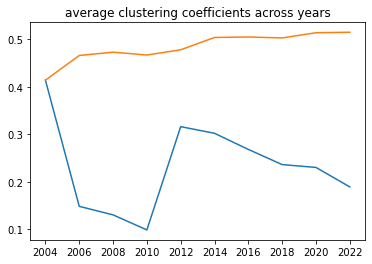

In [8]:
plt.plot(years, hk_avg_ccs)
plt.plot(years, avg_ccs)
print(hk_avg_ccs)
print(avg_ccs)
plt.xticks(years)
plt.title("average clustering coefficients across years")
plt.show()